## Introduction
This is a predictive model built on customer data from "Beta Bank".  It's aim is to predict whether a customer is likely to leave "Beta Bank" soon, based on past client's behavior. Our minimum model threshold is an F1 score (the weighted harmonic mean of the precision and recall scores) of 0.59 or greater.  Additionally, we will measure the AUC-ROC (Area Under the Receiver Operating Characteristic curve) metric both graphically and numerically, as well as sanity check the model against a predictive constant model that assumes no customer exits, to ensure our model is better than random chance.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

## Preprocess customer data
Let's first get an overview of our data, and check it for any missing or duplicate values, and class imbalances.  We will drop any duplicate rows, or rows with missing data.  Looking at our target data we see that there is a clear class imbalance between customers who exit the banking institution, and those who don't. Almost, 80% of our target class remain with the bank.

In [2]:
df = pd.read_csv('/datasets/Churn.csv') # read in churn data
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
df.info() # get dataframe info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df = df.dropna() # drop rows with Nan values

In [5]:
df.dtypes # get data types for all features

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [6]:
df.describe() # get a general overview of all the data in the dataframe

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,9091.000000,9.091000e+03,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000
mean,5013.909911,1.569105e+07,650.736553,38.949181,4.997690,76522.740015,1.530195,0.704983,0.515565,100181.214924,0.203938
std,2884.433466,7.161419e+04,96.410471,10.555581,2.894723,62329.528576,0.581003,0.456076,0.499785,57624.755647,0.402946
min,1.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,2521.500000,1.562899e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,51227.745000,0.000000
50%,5019.000000,1.569106e+07,652.000000,37.000000,5.000000,97318.250000,1.000000,1.000000,1.000000,100240.200000,0.000000
75%,7511.500000,1.575285e+07,717.000000,44.000000,7.000000,127561.890000,2.000000,1.000000,1.000000,149567.210000,0.000000
max,9999.000000,1.581566e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [7]:
df.duplicated().sum() # check the dataframe for duplicate rows

0

In [8]:
df['CustomerId'].duplicated().sum() # check CustomerId column for duplicates

0

In [9]:
df['Exited'].value_counts().to_frame() # check for an class imbalance of customers who have exited vs. those who remain customers

,Exited
0,7237
1,1854


In [10]:
print('Exit percent: {:.2%}'.format(df['Exited'].mean())) # express the class imbalance as a percent

Exit percent: 20.39%


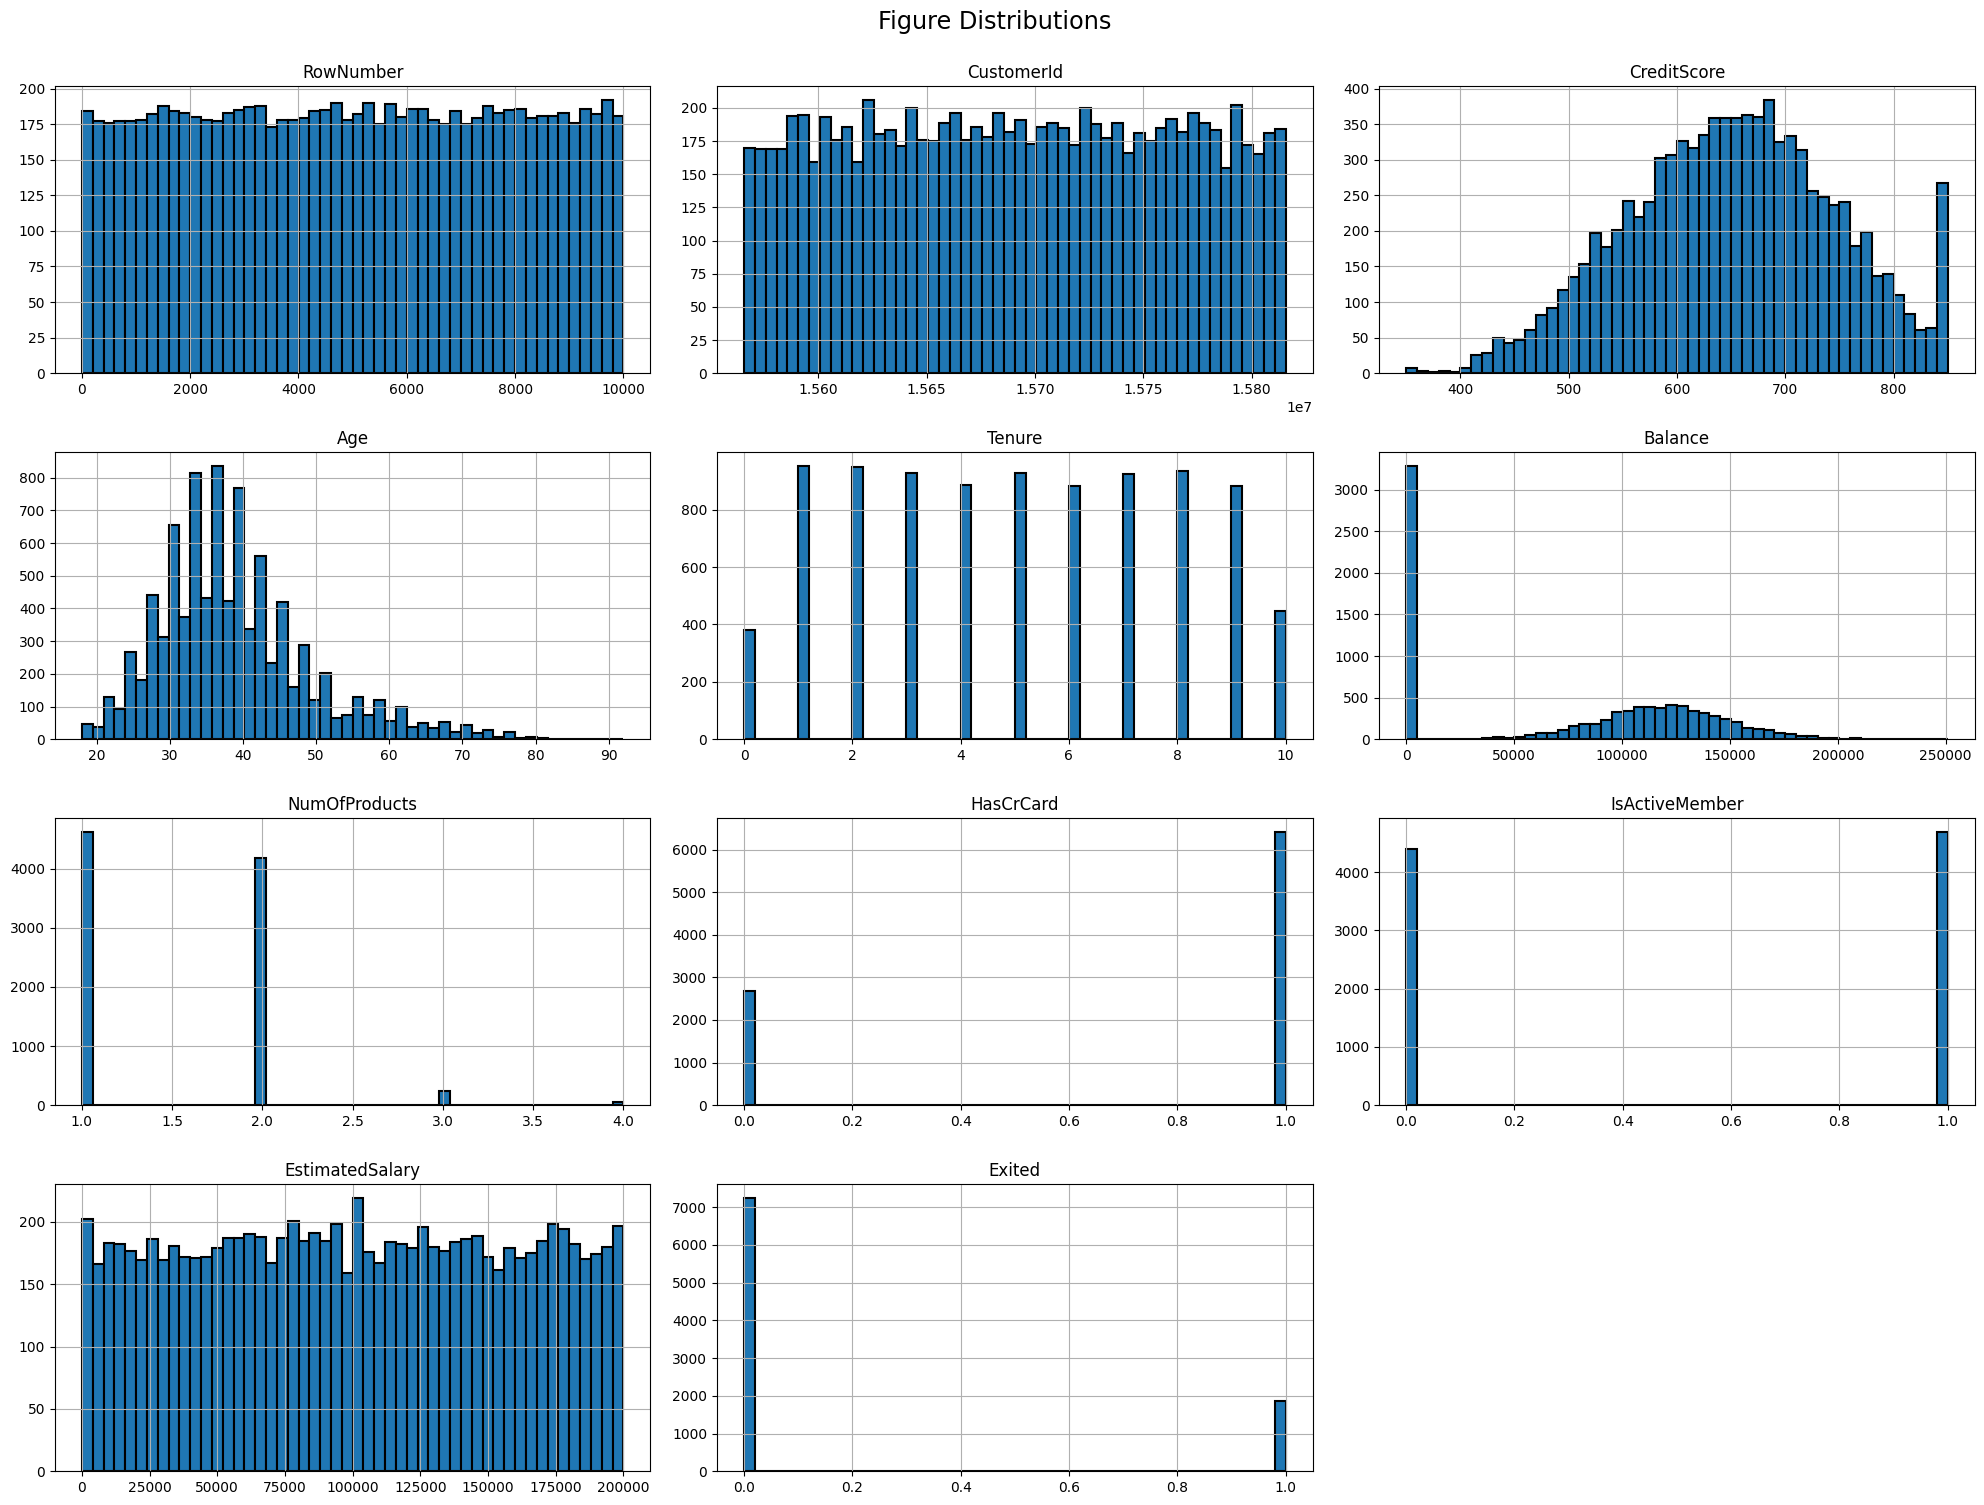

In [11]:
df.hist(bins=50, figsize=(20, 15), edgecolor='black', linewidth=1.5) # a graphical look at all columns in the dataframe
plt.suptitle('Figure Distributions', x=0.5, y=1.0, ha='center', fontsize='xx-large')
plt.tight_layout()
plt.show()

## Split the data and prepare the features
To get our data ready to model, we will first split it into our features and target sets, eliminating any erroneous columns. Then split those sets into 20% for testing, and 80% for training our model. We will then transform our categorical features (gender and geography) by One-Hot encoding them into numerical ones, and replacing the categorical columns in our data set for our model to better analyze. Furthermore, we will standardize any large-scale numerical data, such as balance and estimated salary, to help our model process those features. We will then use GridSearchCV to cross validate our models for final training.

In [12]:
target = df['Exited'] # isolate the target set
features = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited']) # isolate the features set
print(target.shape)
print(features.shape) # get data shapes of each set

(9091,)
(9091, 10)


In [13]:
gender_ohe = pd.get_dummies(features['Gender'], drop_first=True) # one hot encode the gender feature
geography_ohe = pd.get_dummies(features['Geography'], drop_first=True) # one hot encode the geography feature

features.drop(['Gender', 'Geography'], axis=1, inplace=True) # drop the former categorical columns

features_ohe = pd.concat([features, gender_ohe, geography_ohe], axis=1) # add the encoded binary columns

features_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1


In [14]:
# split the data into train(80%), test(20%)
# training and test sets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.20, random_state=12345)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(7272, 8)
(7272,)
(1819, 8)
(1819,)


In [15]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric]) # scale the training features with a large range of numeric values
features_test[numeric] = scaler.transform(features_test[numeric]) # scale the test features with a large range of numeric values
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7702,2.074009,-0.755896,1.032080,-1.235435,2,1,0,1.351774
4303,-0.790263,1.609084,-0.688132,1.249209,1,0,1,0.257662
7470,2.074009,0.757691,-0.344090,0.358445,2,1,1,0.373276
5189,1.825841,0.190096,-0.000047,1.117429,2,0,0,1.391016
699,0.957253,-0.566697,-1.720259,1.682729,1,1,1,0.122738


## Selecting and training a model w/o resampling

Let's first look at selecting and training our model without balancing the class_weight parameter, and then with class_weight='balanced' to see how each performs without any resampling of the data.  We will cross validate and optimize the hyperparameters of three different classification models: Random Forrest, Decision Tree, and Logistic Regression.  As it turns out, the Random Forrest and Decision Tree models perform almost comparably well with the unresampled data. All models here perform best with the 'balanced' class_weight. The Random Forrest has a slightly better F1 score, so we will utilize it for training and testing our preliminary model.

In [ ]:
# tune hyperparameters on random forest classifier
rfc = RandomForestClassifier(random_state=12345)
forest_params = [{'max_depth': list(range(1, 14)), 'n_estimators': list(range(1, 50)), 'class_weight': [None, 'balanced']}] # signify which hyperparameters to target
clf = GridSearchCV(rfc, forest_params, cv=10, scoring='f1')
clf.fit(features_train, target_train)
print(clf.best_params_)
print(clf.best_score_)

In [ ]:
# tune hyperparameters on decision tree classifier
dtc = DecisionTreeClassifier(random_state=12345)
tree_params = [{'max_depth': list(range(1, 14)), 'criterion': ['gini', 'entropy'], 'class_weight': [None, 'balanced']}] # signify which hyperparameters to target
clf_a = GridSearchCV(dtc, tree_params, cv=10, scoring='f1')
clf_a.fit(features_train, target_train)
print(clf_a.best_params_)
print(clf_a.best_score_)

In [ ]:
# tune hyperparameters on logistic regression classifier
lrc = LogisticRegression(random_state=12345)
lr_params = [{'solver': ['newton-cg', 'liblinear'], 'C': [0.01, 0.05, 0.10, 0.50, 0.75, 1.00], 'class_weight': [None, 'balanced']}] # signify which hyperparameters to target
clf_b = GridSearchCV(lrc, lr_params, cv=10, scoring='f1')
clf_b.fit(features_train, target_train)
print(clf_b.best_params_)
print(clf_b.best_score_)

## Train and test the Random Forrest Classifier model
Using our optimized hyperparameters, we will train our random forrest on our training set and test it's ability to predict customer exits using the test set we isolated earlier.  Doing so gives an Accuracy score of 0.80, and on testing gives us an F1 score of 0.58, below our miniumum allowable standard of 0.59 

In [16]:
# run the test features through the first random forest classifier model with unresampled data to analyze F1 and accuracy
rfc1_model = RandomForestClassifier(random_state=12345, max_depth=8, max_features='auto', n_estimators=43, class_weight='balanced')
rfc1_model.fit(features_train, target_train)
train_predictions = rfc1_model.predict(features_train)
test_predictions = rfc1_model.predict(features_test)
print('F1 Unresampled Trained Score:', f1_score(target_train, train_predictions))
print('F1 Unresampled Test Score:', f1_score(target_test, test_predictions))
print('Accuracy Unresampled Test Score:', accuracy_score(target_test, test_predictions))

F1 Unresampled Trained Score: 0.6485061511423551
F1 Unresampled Test Score: 0.5804935370152761
Accuracy Unresampled Test Score: 0.8037383177570093


## Calculate and plot the unbalanced AUC-ROC curve
Here we see a nice curve above random with a score of 0.84, indicating "moderate-good" model quality.  However, this could be an overly optimistic assesment based on our unbalanced data in which the negative class far outweighs the positive class, making the FPR (False Positive Rate) in our curve less sensitive to changes in predictions of the minority class.  Let's balance the classes and take another look to verify.

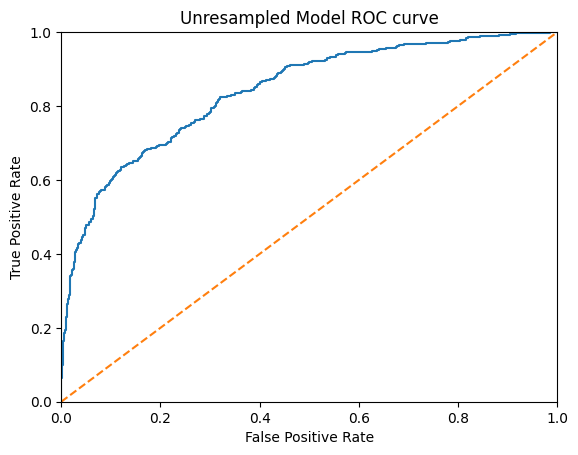

In [17]:
probabilities_test = rfc1_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Unresampled Model ROC curve')
plt.show()

In [18]:
auc_roc = roc_auc_score(target_test, probabilities_one_test) # calculate the Area Under Curve Receiver Operating Characteristic score 
print('ROC AUC Score:', auc_roc)

ROC AUC Score: 0.8395402298850575


## Upsample the data
Let's even out the class imbalance by writing a function to upsample, as well as downsample our data. This should help balance the weights of our positive and negative classes.

In [19]:
# function to balance the classes utilizing upsampling
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)
print(features_upsampled.shape)
print(target_upsampled.shape)

(10242, 8)
(10242,)


## Re-select and train our model
Let's again cross validate and tune our classifier models to select the appropriate one, first with the upsampled data, and next with the downsampled data.  Again, the Random Forrest model is the top performer with the upsampled data, this time with an F1 of 0.93, better than both the decision tree and logistic regression models. However, the random forrest and decision tree models performed about equally when given the downsampled data. The models tuned on both the upsampled and downsampled data show much better F1's all around when compared to the same models tuned and trained on unresampled data.

In [ ]:
# tune hyperparameters on random forest classifier
rfc = RandomForestClassifier(random_state=12345)
forest_params = [{'max_depth': list(range(4, 30)), 'n_estimators': list(range(10, 60)), 'max_features': ['auto'], 'min_samples_split': list(range(5, 15))}] # signify which hyperparameters to target
clf_c = GridSearchCV(rfc, forest_params, cv=10, scoring='f1')
clf_c.fit(features_upsampled, target_upsampled)
print(clf_c.best_params_)
print(clf_c.best_score_)

In [ ]:
# tune hyperparameters on decision tree classifier
dtc = DecisionTreeClassifier(random_state=12345)
tree_params = [{'max_depth': list(range(1, 14)), 'criterion': ['gini', 'entropy']}] # signify which hyperparameters to target
clf_d = GridSearchCV(dtc, tree_params, cv=10, scoring='f1')
clf_d.fit(features_upsampled, target_upsampled)
print(clf_d.best_params_)
print(clf_d.best_score_)

In [ ]:
# tune hyperparameters on logistic regression classifier
lrc = LogisticRegression(random_state=12345)
lr_params = [{'solver': ['newton-cg', 'liblinear'], 'C': [0.01, 0.05, 0.10, 0.50, 0.75, 1.00]}] # signify which hyperparameters to target
clf_e = GridSearchCV(lrc, lr_params, cv=10, scoring='f1')
clf_e.fit(features_upsampled, target_upsampled)
print(clf_e.best_params_)
print(clf_e.best_score_)

In [20]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones])
    
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)
print(features_downsampled.shape)
print(target_downsampled.shape)

(2064, 8)
(2064,)


In [ ]:
# tune hyperparameters on random forest classifier
rfc = RandomForestClassifier(random_state=12345)
forest_params = [{'max_depth': list(range(1, 14)), 'n_estimators': list(range(1, 50))}] # signify which hyperparameters to target
clf_f = GridSearchCV(rfc, forest_params, cv=10, scoring='f1')
clf_f.fit(features_downsampled, target_downsampled)
print(clf_f.best_params_)
print(clf_f.best_score_)

In [ ]:
# tune hyperparameters on decision tree classifier
dtc = DecisionTreeClassifier(random_state=12345)
tree_params = [{'max_depth': list(range(1, 14)), 'criterion': ['gini', 'entropy']}] # signify which hyperparameters to target
clf_g = GridSearchCV(dtc, tree_params, cv=10, scoring='f1')
clf_g.fit(features_downsampled, target_downsampled)
print(clf_g.best_params_)
print(clf_g.best_score_)

In [ ]:
# tune hyperparameters on logistic regression classifier
lrc = LogisticRegression(random_state=12345)
lr_params = [{'solver': ['newton-cg','liblinear'], 'C': [0.01, 0.05, 0.10, 0.50, 0.75, 1.00]}] # signify which hyperparameters to target
clf_h = GridSearchCV(lrc, lr_params, cv=10, scoring='f1')
clf_h.fit(features_downsampled, target_downsampled)
print(clf_h.best_params_)
print(clf_h.best_score_)

## Re-train and re-test the Random Forrest model
Using the upsampled and downsampled data, and reoptimized hyperparameters let's test the model again and examine the differences.  Doing so gets us an accuracy score of 0.84 up from 0.81 with the unresampled set, and a F1 on the test set of 0.60, which puts our Random Forest model trained on the upsampled data above the pre-prescribed F1 of 0.59. Let's also look at a Random Forest model trained on the downsampled data as well. It appears to have faired much worse, with a test F1 of 0.44, and accuracy score of just 0.53.  Upsampled data wins the day!

In [21]:
rfc2_model = RandomForestClassifier(random_state=12345, max_depth=24, n_estimators=43, max_features='auto', min_samples_split=15)
rfc2_model.fit(features_upsampled, target_upsampled)
upsamp_train_predictions = rfc2_model.predict(features_train)
upsamp_test_predictions = rfc2_model.predict(features_test)
print('F1 Upsampled Trained Score:', f1_score(target_train, upsamp_train_predictions))
print('F1 Upsampled Test Score;', f1_score(target_test, upsamp_test_predictions))
print('Accuracy Balanced Test Score:', accuracy_score(target_test, upsamp_test_predictions))

F1 Upsampled Trained Score: 0.9220945083014047
F1 Upsampled Test Score; 0.5986206896551723
Accuracy Balanced Test Score: 0.840021990104453


In [22]:
# run the downsampled test features through the final, optimized random forest classifier model to analyze F1 and accuracy
rfc3_model = RandomForestClassifier(random_state=12345, max_depth=9, max_features='auto', n_estimators=32)
rfc3_model.fit(features_downsampled, target_downsampled)
downsamp_train_predictions = rfc3_model.predict(features_train)
downsamp_test_predictions = rfc3_model.predict(features_test)
print('F1 Downsampled Trained Score:', f1_score(target_train, downsamp_train_predictions))
print('F1 Downsampled Test Score;', f1_score(target_test, downsamp_test_predictions))
print('Accuracy Balanced Test Score:', accuracy_score(target_test, downsamp_test_predictions))

F1 Downsampled Trained Score: 0.48047650562541366
F1 Downsampled Test Score; 0.4480731548007838
Accuracy Balanced Test Score: 0.5354590434304562


## Calculate and plot the balanced AUC-ROC curve
Here we get another nice curve above random with a AUC-ROC score of 0.83 indicating "moderate-good" model quaility again, however this time we can be more secure knowing that the FPR is less biased after balancing the classes.

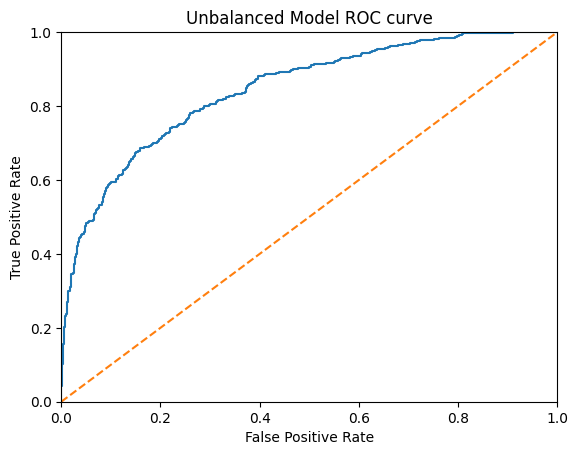

In [23]:
probabilities_test_b = rfc2_model.predict_proba(features_test) # calculate the class probabilities on the test set 
probabilities_one_test_b = probabilities_test_b[:, 1]

fpr_b, tpr_b, thresholds_b = roc_curve(target_test, probabilities_one_test_b)

plt.figure()
plt.plot(fpr_b, tpr_b)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Unbalanced Model ROC curve')
plt.show()

In [24]:
auc_roc_bal = roc_auc_score(target_test, probabilities_one_test_b) # calculate the Area Under Curve Receiver Operating Characteristic score 
print('Balanced ROC AUC Score:', auc_roc_bal)

Balanced ROC AUC Score: 0.843068872068031


## Sanity Check
Let's perform a final sanity check on our model to ensure it's accurate beyond random using a constant model that predicts no customer exits.  Here we see an accuracy score of 0.80, below how our final model tested on the balanced dataset at 0.84.  This means our model is better than random.

In [25]:
target_pred_constant = pd.Series(0, index=target.index) # compare the accuracy of a constant model that predicts '0' 100% of the time
print('Constant Model Accuracy:', accuracy_score(target, target_pred_constant))

Constant Model Accuracy: 0.7960620393796062


## Conclusion
Utilizing past customer data from "Beta Bank" to tune and test Random Forest, Decision Tree, and Logistic Regression classification models on both the unbalanced, and resampled versions of the data, it became apparent that the Random Forrest Classifier model was the best option for this particular dataset. Training and testing the final optimized Random Forest model on the upsampled data, the new algorithm's F1 score is 0.60, which adheres to the minimum required threshold of 0.59. Additionally, the model's AUC-ROC score is well above random, signaling overall good performance. We now have a model that is able to analyze and predict customer turnover.  This model will help "Beta Bank" pinpoint potential customer exits before they happen, and allow them to react in order to retain exisiting customers moving forward.